In [50]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import streamlit as st ## for the dashboard

## Loading specific datasets in the folder_path

In [2]:
folder_path = r"/Users/bertrandnkongdem/Downloads/Data Analytics Portfolio/End-to-End-Ecommerce-Pipeline/ecommerce datasets"

def load_csv(filename):
    return pd.read_csv(os.path.join(folder_path, filename))

orders       = load_csv('olist_orders_dataset.csv')
location     = load_csv('olist_geolocation_dataset.csv')
order_items  = load_csv('olist_order_items_dataset.csv')
products     = load_csv('olist_products_dataset.csv')
product_cat_trans = load_csv('product_category_name_translation.csv')
customers    = load_csv('olist_customers_dataset.csv')
sellers      = load_csv('olist_sellers_dataset.csv')
reviews      = load_csv('olist_order_reviews_dataset.csv')
payments     = load_csv('olist_order_payments_dataset.csv')

## Overview of the data loaded

In [9]:
print("\nLoaded datasets (showing shapes where available):")
for name, df in [('orders', orders), ('location', location), ('order_items', order_items),
                 ('products', products), ('product_cat_trans', product_cat_trans),
                 ('customers', customers), ('sellers', sellers), ('reviews', reviews), ('payments', payments)]:
    if df is None:
        print(f" - {name}: NOT FOUND")
    else:
        print(f" - {name}: {df.shape}")


Loaded datasets (showing shapes where available):
 - orders: (99441, 8)
 - location: (1000163, 5)
 - order_items: (112650, 7)
 - products: (32951, 9)
 - product_cat_trans: (71, 2)
 - customers: (99441, 5)
 - sellers: (3095, 4)
 - reviews: (99224, 7)
 - payments: (103886, 5)


## Standardizing names and parse dates

In [3]:
# Standardize column names (lowercase, underscores)
for df in [orders, location, order_items, products, product_cat_trans, customers, sellers, reviews, payments]:
    df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [5]:
# Auto-detect and convert timestamp-like columns in each DataFrame
time_keywords = ['date', 'timestamp', 'time']
for name, df in [('orders', orders), ('order_items', order_items), ('reviews', reviews), ('payments', payments),
                 ('products', products), ('customers', customers), ('sellers', sellers), ('location', location)]:
    if df is None:
        continue
    for col in df.columns:
        low = col.lower()
        for key in time_keywords:
            if key in low:
                # try to convert this column to datetime
                try:
                    df[col] = pd.to_datetime(df[col], errors='coerce')
                except Exception:
                    # skip if conversion fails
                    pass
                break



In [6]:
product_cat_trans

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
66,flores,flowers
67,artes_e_artesanato,arts_and_craftmanship
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes


In [7]:
products.head()# checking if the product_category_name_english has been added to the products table

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [38]:
#Merge English category name into products
products = products.merge(product_cat_trans, how='left', on='product_category_name')
if 'product_category_name_english' in products.columns:
   products = products.rename(columns={'product_category_name_english':'product_name_english'})

In [39]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category_english,product_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares,housewares


In [8]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


In [23]:
# Fill missing review comments
if reviews is not None and 'review_comment_message' in reviews.columns:
    reviews['review_comment_message'] = reviews['review_comment_message'].fillna('No review')


In [24]:
reviews.head() # checking if the No review has been inserted

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,No review,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,No review,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,No review,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


In [25]:
exact_dup_count = products.duplicated().sum()
print("Exact duplicate rows in products:", exact_dup_count)
# view them:
products[products.duplicated(keep=False)].head(50)

Exact duplicate rows in products: 0


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category_english,category_english


## Checking for duplicates 

In [9]:
# Put your DataFrames into a dict and check for duplicates 

tables = {
    'orders': orders,
    'order_items': order_items,
    'products': products,
    'product_cat_trans': product_cat_trans,
    'customers': customers,
    'sellers': sellers,
    'reviews': reviews,
    'payments': payments,
    'location': location  
}

for name, df in tables.items():
    if df is None:
        print(f"{name}: NOT LOADED")
        continue

    print(f"\nTable: {name}")
    print(" - rows:", len(df))
    # exact duplicate rows
    exact_dups = df.duplicated().sum()
    print(" - exact duplicate rows:", exact_dups)

    # find columns that look like IDs
    id_cols = [c for c in df.columns if 'id' in c.lower()]
    if not id_cols:
        print(" - no id-like columns found")
        continue

    for col in id_cols:
        dup_rows_with_key = df[col].duplicated().sum()
        unique_keys = df[col].nunique(dropna=True)
        total_nonnull = df[col].notna().sum()
        print(f"   * {col}: duplicated rows = {dup_rows_with_key}, unique keys = {unique_keys}, non-null = {total_nonnull}")

        # show up to 5 example duplicated key values (if any)
        if dup_rows_with_key > 0:
            dup_vals = df[df[col].duplicated(keep=False)][col].unique()[:5]
            print(f"     example duplicated {col} values (up to 5): {list(dup_vals)}")


Table: orders
 - rows: 99441
 - exact duplicate rows: 0
   * order_id: duplicated rows = 0, unique keys = 99441, non-null = 99441
   * customer_id: duplicated rows = 0, unique keys = 99441, non-null = 99441

Table: order_items
 - rows: 112650
 - exact duplicate rows: 0
   * order_id: duplicated rows = 13984, unique keys = 98666, non-null = 112650
     example duplicated order_id values (up to 5): ['0008288aa423d2a3f00fcb17cd7d8719', '00143d0f86d6fbd9f9b38ab440ac16f5', '001ab0a7578dd66cd4b0a71f5b6e1e41', '001d8f0e34a38c37f7dba2a37d4eba8b', '002c9def9c9b951b1bec6d50753c9891']
   * order_item_id: duplicated rows = 112629, unique keys = 21, non-null = 112650
     example duplicated order_item_id values (up to 5): [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
   * product_id: duplicated rows = 79699, unique keys = 32951, non-null = 112650
     example duplicated product_id values (up to 5): ['4244733e06e7ecb4970a6e2683c13e61', 'c777355d18b72b67abbeef9df44fd0fd', '7634da

## Building order-level aggregates

In [11]:
#total paid per order (payments table)
payments_agg = payments.groupby('order_id', as_index=False)['payment_value'].sum().rename(columns={'payment_value':'total_paid'})

# join payments total into orders
orders = orders.merge(payments_agg, how='left', on='order_id')

# merge review score (mean) to orders
if 'review_score' in reviews. columns:
    reviews_agg = reviews.groupby('order_id', as_index=False)['review_score'].mean()
    orders = orders.merge(reviews_agg, how='left', on='order_id')

# compute delivery metrics
orders['delivered_flag'] = orders['order_delivered_customer_date'].notna()
orders['delivery_days'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days


## Building customer-level aggregates

In [21]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,total_paid_x,review_score_x,total_paid_y,review_score_y,delivered_flag,delivery_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,38.71,4.0,38.71,4.0,True,8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,141.46,4.0,141.46,4.0,True,13.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,179.12,5.0,179.12,5.0,True,9.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,72.20,5.0,72.20,5.0,True,13.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,28.62,5.0,28.62,5.0,True,2.0


In [24]:
# build total_paid and merge into orders
print("payments columns:", payments.columns.tolist()[:10])
print("order_items columns:", order_items.columns.tolist()[:10])

if 'payment_value' in payments.columns:
    payments_agg = payments.groupby('order_id', as_index=False)['payment_value']\
                          .sum().rename(columns={'payment_value':'total_paid'})
    print("Using payments.payment_value to compute total_paid.")
elif 'price' in order_items.columns:
    payments_agg = order_items.groupby('order_id', as_index=False)['price']\
                              .sum().rename(columns={'price':'total_paid'})
    print("Using order_items.price to compute total_paid.")
else:
    payments_agg = pd.DataFrame({'order_id': orders['order_id'].unique(), 'total_paid': 0.0})
    print("No payment or price column found — setting total_paid = 0 for all orders.")

# Merge into orders and fill missing with 0
orders = orders.merge(payments_agg, how='left', on='order_id')
orders['total_paid'] = orders['total_paid'].fillna(0.0)

print("Merged total_paid into orders. Sample:")
print(orders[['order_id','total_paid']].head())

payments columns: ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']
order_items columns: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
Using payments.payment_value to compute total_paid.
Merged total_paid into orders. Sample:
                           order_id  total_paid
0  e481f51cbdc54678b7cc49136f2d6af7       38.71
1  53cdb2fc8bc7dce0b6741e2150273451      141.46
2  47770eb9100c2d0c44946d9cf07ec65d      179.12
3  949d5b44dbf5de918fe9c16f97b45f8a       72.20
4  ad21c59c0840e6cb83a9ceb5573f8159       28.62


## Performing EDA and segmentation by Computing RFM scores

In [54]:
# define "today" for recency calculation
# customer-level aggregates (for RFM)
#  - Recency: days since last purchase
#  - Frequency: count of orders
#  - Monetary: total paid (use orders.total_paid)
latest_purchase = orders['order_purchase_timestamp'].max()
today = latest_purchase.normalize() + pd.Timedelta(days=1)

cust = orders.groupby(group_key).agg({
    'order_purchase_timestamp': 'max',   # last purchase
    'order_id': 'nunique',               # frequency (number of orders)
    'total_paid': 'sum'                  # monetary (total money spent)
}).reset_index().rename(columns={
    'order_purchase_timestamp': 'last_purchase',
    'order_id': 'frequency',
    'total_paid': 'monetary'
})

cust['recency_days'] = (today - cust['last_purchase']).dt.days
cust['monetary'] = cust['monetary'].fillna(0.0)
print("Built customer aggregates (RFM).")
cust_agg.head()

Built customer aggregates (RFM).


,customer_id,last_purchase,frequency,monetary,recency_days,R_score,F_score,M_score,RFM_score,cluster
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,1,114.74,337,2,1,3,213,1
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,1,67.41,458,1,1,2,112,2
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,1,195.42,596,1,1,4,114,2
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,1,179.35,427,2,1,4,214,2
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,1,107.01,198,4,1,3,413,1


In [28]:
# score R, F, M using quantiles (1 means worst and 5 means best)
cust_agg['R_score'] = pd.qcut(cust_agg['recency_days'], 5, labels=[5,4,3,2,1]).astype(int)
cust_agg['F_score'] = pd.qcut(cust_agg['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
cust_agg['M_score'] = pd.qcut(cust_agg['monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

cust_agg['RFM_score'] = cust_agg['R_score'].astype(str) + cust_agg['F_score'].astype(str) + cust_agg['M_score'].astype(str)
print(cust_agg[['customer_id','recency_days','frequency','monetary','R_score','F_score','M_score']].head(10))


                        customer_id  recency_days  frequency  monetary  \
0  00012a2ce6f8dcda20d059ce98491703           337          1    114.74   
1  000161a058600d5901f007fab4c27140           458          1     67.41   
2  0001fd6190edaaf884bcaf3d49edf079           596          1    195.42   
3  0002414f95344307404f0ace7a26f1d5           427          1    179.35   
4  000379cdec625522490c315e70c7a9fb           198          1    107.01   
5  0004164d20a9e969af783496f3408652           553          1     71.80   
6  000419c5494106c306a97b5635748086           229          1     49.40   
7  00046a560d407e99b969756e0b10f282           303          1    166.59   
8  00050bf6e01e69d5c0fd612f1bcfb69c           395          1     85.23   
9  000598caf2ef4117407665ac33275130            67          1   1255.71   

   R_score  F_score  M_score  
0        2        1        3  
1        1        1        2  
2        1        1        4  
3        2        1        4  
4        4        1        3  

In [55]:
# score R, F, M using quantiles (1 means worst and 5 means best)
# Recency: lower is better, so qcut labels reversed
cust['R_score'] = pd.qcut(cust['recency_days'], 5, labels=[5,4,3,2,1]).astype(int)
# Frequency & Monetary: higher is better
# use rank then qcut to handle ties and zeros safely
cust['F_rank'] = cust['frequency'].rank(method='first')
cust['M_rank'] = cust['monetary'].rank(method='first')
cust['F_score'] = pd.qcut(cust['F_rank'], 5, labels=[1,2,3,4,5]).astype(int)
cust['M_score'] = pd.qcut(cust['M_rank'], 5, labels=[1,2,3,4,5]).astype(int)

cust['RFM_score'] = cust['R_score'].astype(str) + cust['F_score'].astype(str) + cust['M_score'].astype(str)

In [56]:
# Preparing numeric RFM and run KMeans with 5 clusters
rfm_numeric = cust[['recency_days','frequency','monetary']].copy()
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_numeric)

kmeans = KMeans(n_clusters=5, random_state=42)
cust['cluster'] = kmeans.fit_predict(rfm_scaled)

In [58]:
# Summarizing clusters and computing a rank-based "goodness" score for auto-labeling
cluster_summary = cust.groupby('cluster').agg({
    'recency_days':'mean',
    'frequency':'mean',
    'monetary':'mean',
    group_key: 'count'   # count of customers in cluster
}).rename(columns={group_key:'count'}).reset_index()

# Compute ranks (1 = best). For recency, lower is better, so ascending=True
cluster_summary['mon_rank'] = cluster_summary['monetary'].rank(ascending=False)
cluster_summary['freq_rank'] = cluster_summary['frequency'].rank(ascending=False)
cluster_summary['rec_rank'] = cluster_summary['recency_days'].rank(ascending=True)

# composite rank (lower = better)
cluster_summary['composite_rank'] = cluster_summary['mon_rank'] + cluster_summary['freq_rank'] + cluster_summary['rec_rank']

# sort clusters by composite_rank and assign human labels
cluster_summary = cluster_summary.sort_values('composite_rank').reset_index(drop=True)

segment_names = ['Champions', 'Loyal Customers', 'Potential Loyalists', 'At Risk', 'Hibernating']
label_map = {}
for i, row in cluster_summary.iterrows():
    label_map[int(row['cluster'])] = segment_names[i]

# attach label to cust and cluster_summary
cust['segment'] = cust['cluster'].map(label_map)
cluster_summary['segment'] = cluster_summary['cluster'].map(label_map)

In [59]:
# Sample marketing messages for each segment
messages = {
    'Champions': "Thank you! Exclusive 15% VIP discount + early access to new products.",
    'Loyal Customers': "We appreciate you—here's 10% off your next order and product recommendations.",
    'Potential Loyalists': "Loved your last purchase? Take 10% off your next order — limited time!",
    'At Risk': "We miss you! Come back with 20% off your next order (one-time use).",
    'Hibernating': "It's been a while — here's 25% off to welcome you back!"
}

cust['message'] = cust['segment'].map(messages)

In [60]:
# Print summary
print("Cluster summary (auto-labeled):")
display(cluster_summary[['cluster','segment','count','recency_days','frequency','monetary']])

print("\nSample customer rows with RFM scores, cluster and messages:")
display(cust[[group_key,'recency_days','frequency','monetary','R_score','F_score','M_score','RFM_score','cluster','segment','message']].head(10))

Cluster summary (auto-labeled):


,cluster,segment,count,recency_days,frequency,monetary
0,0,Champions,4801,276.693189,1.0,667.934149
1,3,Loyal Customers,677,292.946824,1.0,1932.844062
2,4,Potential Loyalists,35469,136.239561,1.0,124.132034
3,2,At Risk,22878,509.038640,1.0,125.444997
4,1,Hibernating,35616,304.925820,1.0,118.508958



Sample customer rows with RFM scores, cluster and messages:


,customer_id,recency_days,frequency,monetary,R_score,F_score,M_score,RFM_score,cluster,segment,message
0,00012a2ce6f8dcda20d059ce98491703,337,1,114.74,2,1,3,213,1,Hibernating,It's been a while — here's 25% off to welcome ...
1,000161a058600d5901f007fab4c27140,458,1,67.41,1,1,2,112,2,At Risk,We miss you! Come back with 20% off your next ...
2,0001fd6190edaaf884bcaf3d49edf079,596,1,195.42,1,1,4,114,2,At Risk,We miss you! Come back with 20% off your next ...
3,0002414f95344307404f0ace7a26f1d5,427,1,179.35,2,1,4,214,2,At Risk,We miss you! Come back with 20% off your next ...
4,000379cdec625522490c315e70c7a9fb,198,1,107.01,4,1,3,413,4,Potential Loyalists,Loved your last purchase? Take 10% off your ne...
5,0004164d20a9e969af783496f3408652,553,1,71.80,1,1,2,112,2,At Risk,We miss you! Come back with 20% off your next ...
6,000419c5494106c306a97b5635748086,229,1,49.40,4,1,1,411,1,Hibernating,It's been a while — here's 25% off to welcome ...
7,00046a560d407e99b969756e0b10f282,303,1,166.59,3,1,4,314,1,Hibernating,It's been a while — here's 25% off to welcome ...
8,00050bf6e01e69d5c0fd612f1bcfb69c,395,1,85.23,2,1,2,212,1,Hibernating,It's been a while — here's 25% off to welcome ...
9,000598caf2ef4117407665ac33275130,67,1,1255.71,5,1,5,515,0,Champions,Thank you! Exclusive 15% VIP discount + early ...


## Saving cleaned data and a short report CSV

In [48]:
# save cleaned outputs
out = os.path.join(folder_path, 'cleaned_simple')
os.makedirs(out, exist_ok=True)

cust_agg.to_csv(os.path.join(out, 'customer_rfm.csv'), index=False)
orders.to_csv(os.path.join(out, 'orders_cleaned.csv'), index=False)
print("Saved customer_rfm.csv and orders_cleaned.csv in", out)

Saved customer_rfm.csv and orders_cleaned.csv in /Users/bertrandnkongdem/Downloads/Data Analytics Portfolio/End-to-End-Ecommerce-Pipeline/ecommerce datasets/cleaned_simple


## Visualizing patterns, and generate actionable business insights

In [40]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category_english,product_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares,housewares


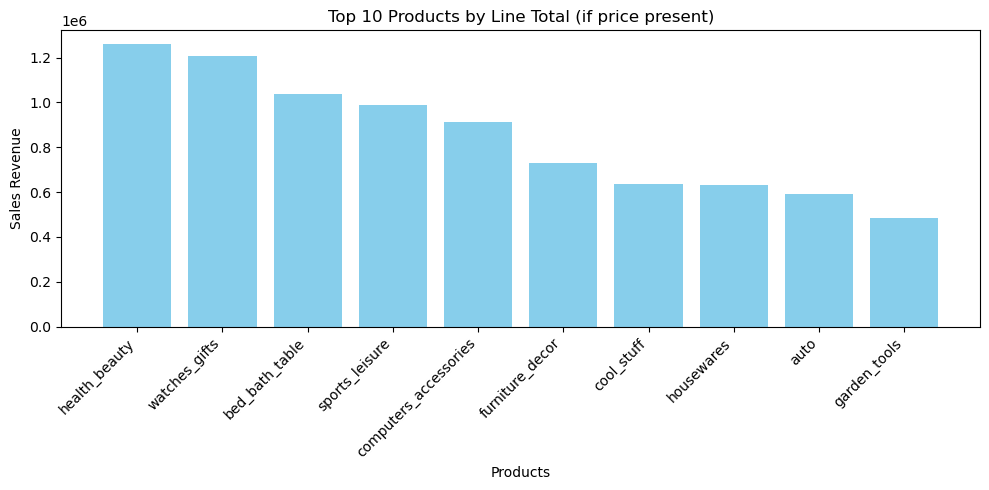

In [43]:

# Top-selling products (by revenue)
top_products = order_items.merge(products[['product_id','product_name_english']], how='left', on='product_id')
top_products['line_total'] = top_products['price'] * top_products['order_item_id'] * 0  # placeholder if price missing
# if price exists, compute line_total properly:
if 'price' in order_items.columns:
    top_products['line_total'] = top_products['price']
top_revenue = top_products.groupby('product_name_english', as_index=False)['line_total'].sum().sort_values('line_total', ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.bar(top_revenue['product_name_english'], top_revenue['line_total'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Products by Line Total (if price present)')
plt.xlabel('Products')
plt.ylabel('Sales Revenue')
plt.tight_layout()
plt.show()

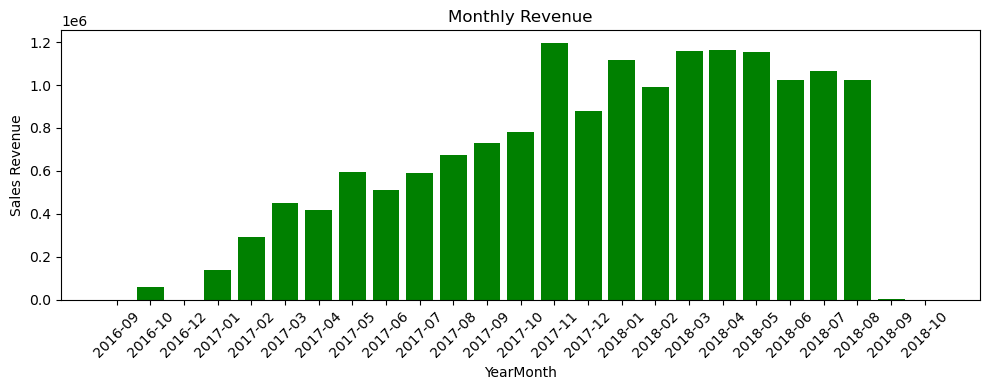

In [46]:
# Monthly sales (order totals)
if 'order_purchase_timestamp' in orders.columns:
    orders['year_month'] = orders['order_purchase_timestamp'].dt.to_period('M').astype(str)
    monthly = orders.groupby('year_month', as_index=False)['total_paid'].sum().sort_values('year_month')
    plt.figure(figsize=(10,4))
    plt.bar(monthly['year_month'], monthly['total_paid'], color='green')
    plt.xticks(rotation=45)
    plt.title('Monthly Revenue')
    plt.xlabel('YearMonth')
    plt.ylabel('Sales Revenue')
    plt.tight_layout()
    plt.show()

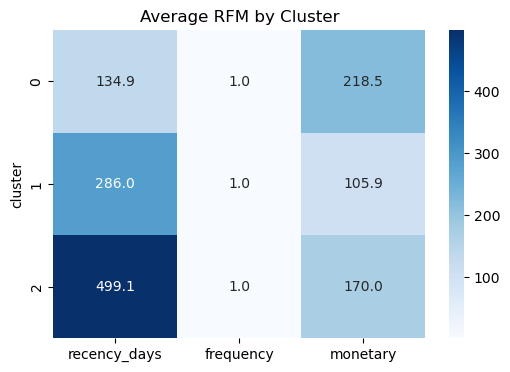

In [47]:
# RFM heatmap by cluster
rfm_by_cluster = cust_agg.groupby('cluster')[['recency_days','frequency','monetary']].mean()
plt.figure(figsize=(6,4))
sns.heatmap(rfm_by_cluster, annot=True, fmt=".1f", cmap='Blues')
plt.title('Average RFM by Cluster')
plt.show()